In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from factor_analyzer.factor_analyzer import calculate_kmo

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)
archivo_csv = "movies_modified.csv"
datos = pd.read_csv(archivo_csv, encoding='ISO-8859-1')

In [4]:
columnas_numericas = datos.select_dtypes(include=['number']).columns.tolist()

# Obtener los nombres de las columnas no numéricas
columnas_no_numericas = datos.select_dtypes(exclude=['number']).columns.tolist()
print("Columnas numéricas:")
print(columnas_numericas)

print("\nColumnas no numéricas:")
print(columnas_no_numericas)

Columnas numéricas:
['id', 'budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount', 'actorsAmount', 'castWomenAmount', 'castMenAmount']

Columnas no numéricas:
['genres', 'homePage', 'productionCompany', 'productionCompanyCountry', 'productionCountry', 'video', 'director', 'actors', 'actorsPopularity', 'actorsCharacter', 'originalTitle', 'title', 'originalLanguage', 'releaseDate']


In [5]:
# Lista de columnas numéricas que usaremos
columnas_numericas = [
    "popularity", "budget", "revenue", "runtime", "genresAmount", 
    "productionCoAmount", "productionCountriesAmount", "voteCount", 
    "voteAvg","actorsAmount", "castWomenAmount", "castMenAmount"
]

# Crear un nuevo DataFrame con solo estas columnas
datos_numericos = datos[columnas_numericas].copy()

# 1.1 Preprocesamiento del dataset #

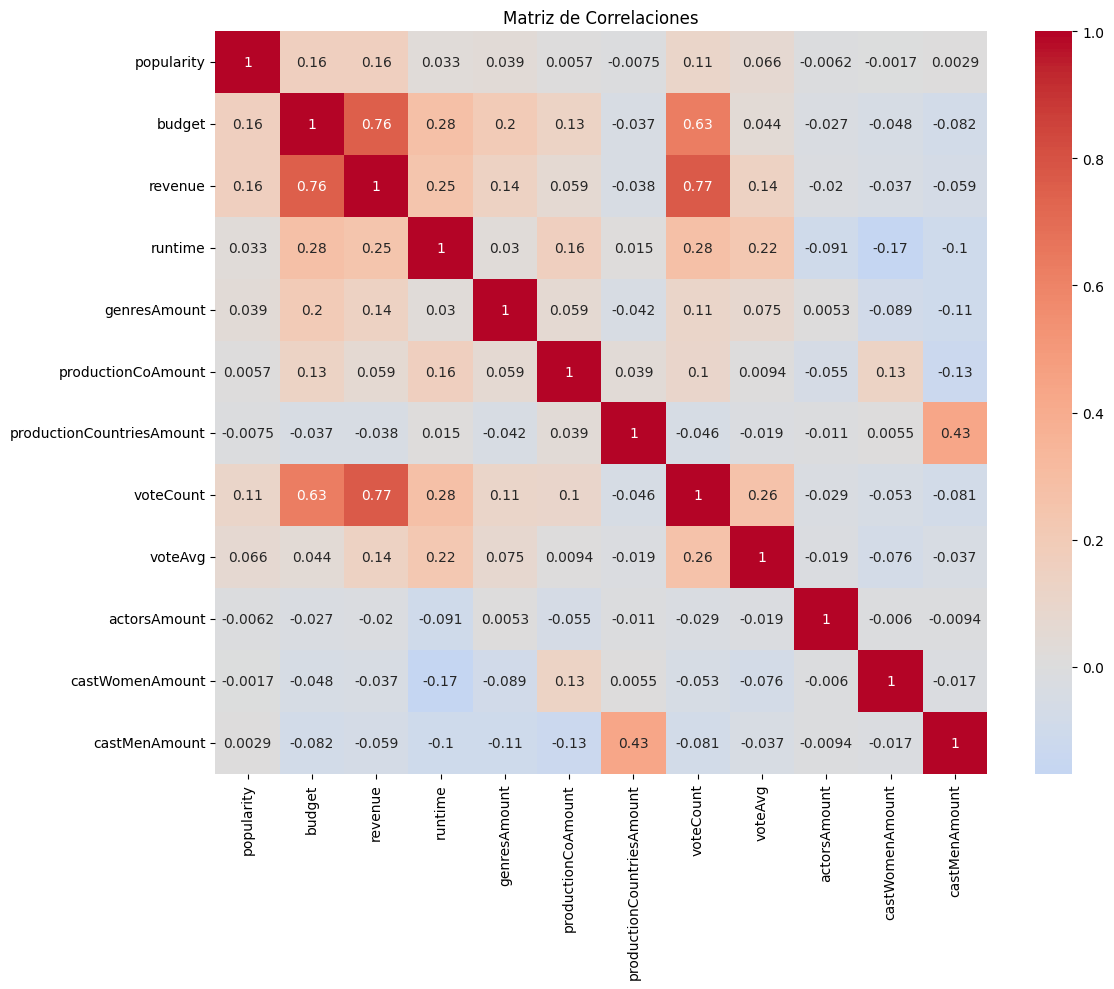

In [6]:
def hopkins_statistic(X):
    X = np.asarray(X)
    n_samples = len(X)
    n_dims = X.shape[1]

    X_uniform = np.random.uniform(
        np.min(X, axis=0),
        np.max(X, axis=0),
        size=(n_samples, n_dims)
    )
    

    neigh = NearestNeighbors(n_neighbors=2)
    neigh.fit(X)
    
    # Distancias para puntos reales
    u_distances, _ = neigh.kneighbors(X_uniform, n_neighbors=1)
    w_distances, _ = neigh.kneighbors(X, n_neighbors=2)
    
    # Calcular estadístico de Hopkins
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances[:, 1])  
    
    return u_sum / (u_sum + w_sum)

# Seleccionar las columnas numéricas
X = datos_numericos[columnas_numericas]

# Calcular matriz de correlaciones
corr_matrix = X.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlaciones')
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Correlaciones fuertes (>0.6):


    budget y revenue (0.76)
    voteCount y revenue (0.77)
    voteCount y budget (0.63)


Correlaciones moderadas (0.4-0.6):

    productionCountriesAmount y castMenAmount (0.43)

Correlaciones débiles o nulas (< 0.4):

    La mayoría de las demás variables muestran correlaciones muy bajas entre sí

Variables que podrían no aportar información única:

revenue ya que esta correlacionada con budget y voteCount, lo que significa que no aporta información única significativa.

Variables que sí aportan información única:

    popularity - correlaciones bajas con todas las demás variables
    runtime - correlaciones bajas con las demás variables
    genresAmount - correlaciones bajas con todas las variables
    productionCoAmount - correlaciones bajas
    voteAvg - correlaciones relativamente bajas
    actorsAmount, castWomenAmount, castMenAmount - aunque relacionadas conceptualmente, muestran correlaciones bajas

Por lo tanto:

Se dejan la mayoría de las variables ya que tienen correlaciones bajas entre sí
Se eliminaria revenue y mantener budget y voteCount
Estandarizar todas las variables debido a sus diferentes escalas

Todo esto con el fin de poder evitar redundancia


In [7]:
# Lista de columnas numéricas que usaremos
columnas_numericas = [
    "popularity", "budget", "runtime", "genresAmount", 
    "productionCoAmount", "productionCountriesAmount", "voteCount", 
    "voteAvg","actorsAmount", "castWomenAmount", "castMenAmount"
]

# Crear un nuevo DataFrame con solo estas columnas
datos_numericos = datos[columnas_numericas].copy()

In [8]:
X = datos_numericos[columnas_numericas]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 1.2 Análisis de la tendencia al agrupamiento #

In [9]:
# 1.2 Estadístico de Hopkins
hopkins_score = hopkins_statistic(X_scaled)
print(f"Estadístico de Hopkins: {hopkins_score:.3f}")

Estadístico de Hopkins: 0.987


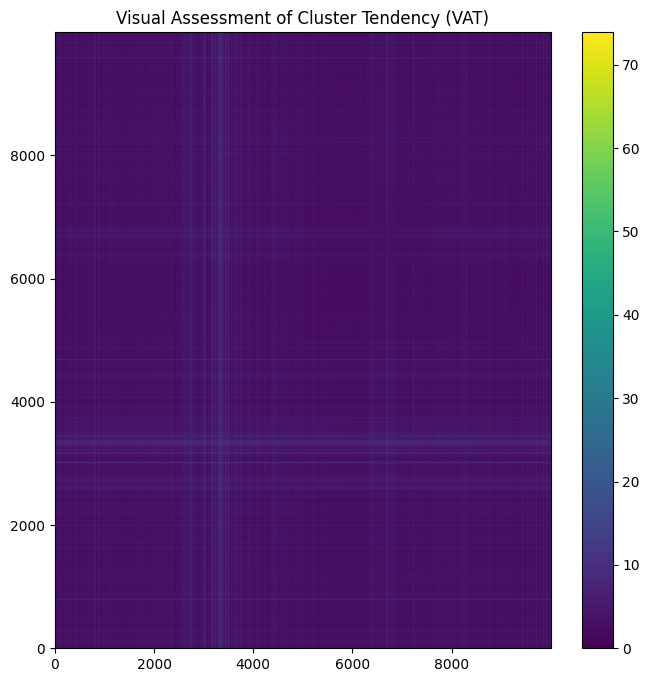

In [12]:
def VAT(X):
    dist_matrix = pdist(X, 'euclidean') 
    dist_matrix = squareform(dist_matrix)
    order = np.argsort(np.min(dist_matrix, axis=0))
    dist_matrix = dist_matrix[order, :][:, order]

    plt.figure(figsize=(8, 8))
    plt.imshow(dist_matrix, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar()
    plt.title('Visual Assessment of Cluster Tendency (VAT)')
    plt.show()

VAT(X_scaled)  

Como el Estadístico de Hopkins fue de 0.987 y ya que este numero esta muy cerca de 1 significa que hay una fuerte tendencia al agrupamiento de los datos.

# 1.3 Determinar el número óptimo de clusters #

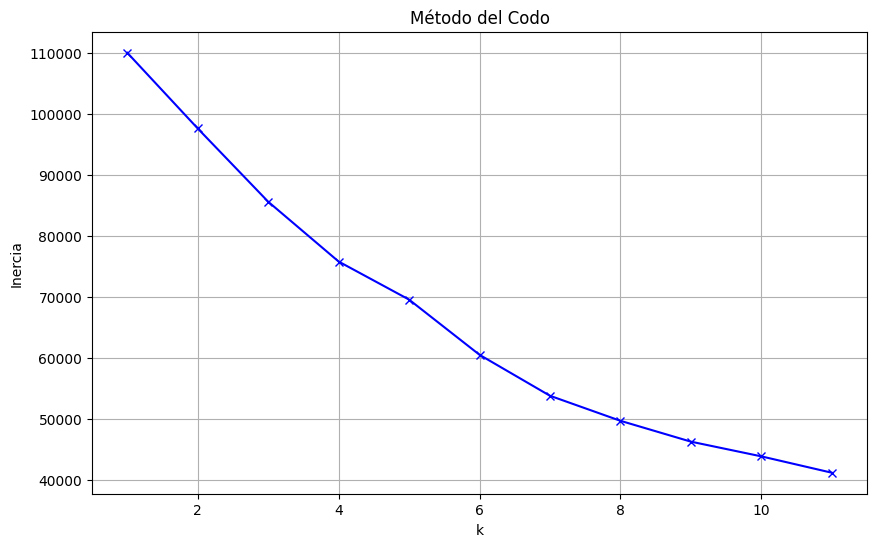

In [16]:

inertias = []
K = range(1, 12)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

Se trabajara con 4 clústeres porque, según lo observado en la gráfica del método del codo, la inercia disminuye considerablemente hasta k=4, y después de este punto la reducción es menos significativa.

# 1.4 Aplicar K-Means y Clustering Jerárquico #

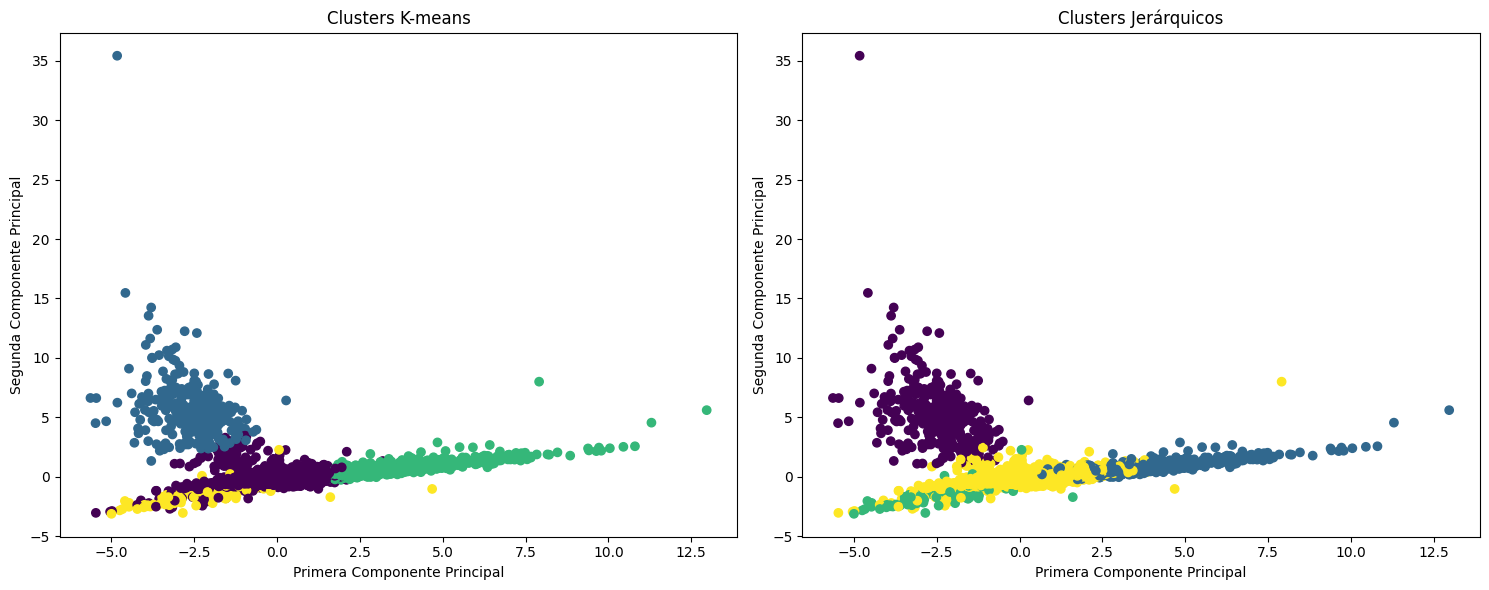


Tamaño de los clusters:

K-means:
Cluster 0: 8675 elementos
Cluster 1: 287 elementos
Cluster 2: 930 elementos
Cluster 3: 108 elementos

Jerárquico:
Cluster 0: 338 elementos
Cluster 1: 614 elementos
Cluster 2: 110 elementos
Cluster 3: 8938 elementos

Comparación de tamaños de clusters:
           K-means  Jerárquico
Cluster 0     8675         338
Cluster 1      287         614
Cluster 2      930         110
Cluster 3      108        8938

Características promedio de cada cluster:

K-means:

Cluster 0 (8675 elementos):
popularity: 39.10
budget: 10427670.67
runtime: 99.00
genresAmount: 2.57
productionCoAmount: 3.09
productionCountriesAmount: 1.43
voteCount: 768.57
voteAvg: 6.44
actorsAmount: 2469.75
castWomenAmount: 308.67
castMenAmount: 670.43

Cluster 1 (287 elementos):
popularity: 46.85
budget: 268102.36
runtime: 82.46
genresAmount: 1.86
productionCoAmount: 1.23
productionCountriesAmount: 11.86
voteCount: 73.45
voteAvg: 6.25
actorsAmount: 3.34
castWomenAmount: 4.79
castMenAmount: 5447

In [17]:
k_optimo = 4

kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)
Z = linkage(X_scaled, method='ward')

clusters_jerarquico = fcluster(Z, k_optimo, criterion='maxclust')
clusters_jerarquico = clusters_jerarquico - 1

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(15, 6))

# K-means
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis')
plt.title('Clusters K-means')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')

# Clustering Jerárquico
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_jerarquico, cmap='viridis')
plt.title('Clusters Jerárquicos')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')

plt.tight_layout()
plt.show()



print("\nTamaño de los clusters:")
print("\nK-means:")
for i in range(k_optimo):
    print(f"Cluster {i}: {np.sum(clusters_kmeans == i)} elementos")

print("\nJerárquico:")
for i in range(k_optimo):
    print(f"Cluster {i}: {np.sum(clusters_jerarquico == i)} elementos")


datos_numericos['Cluster_KMeans'] = clusters_kmeans
datos_numericos['Cluster_Hierarchical'] = clusters_jerarquico

sizes_comparison = pd.DataFrame({
    'K-means': [np.sum(clusters_kmeans == i) for i in range(k_optimo)],
    'Jerárquico': [np.sum(clusters_jerarquico == i) for i in range(k_optimo)]
}, index=[f'Cluster {i}' for i in range(k_optimo)])

print("\nComparación de tamaños de clusters:")
print(sizes_comparison)

print("\nCaracterísticas promedio de cada cluster:")

print("\nK-means:")
for i in range(k_optimo):
    cluster_data = datos_numericos[datos_numericos['Cluster_KMeans'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} elementos):")
    means = cluster_data[columnas_numericas].mean()
    for col, mean in means.items():
        print(f"{col}: {mean:.2f}")

print("\nJerárquico:")
for i in range(k_optimo):
    cluster_data = datos_numericos[datos_numericos['Cluster_Hierarchical'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} elementos):")
    means = cluster_data[columnas_numericas].mean()
    for col, mean in means.items():
        print(f"{col}: {mean:.2f}")

K-means tiende a generar grupos más compactos y definidos. Por otro lado, el Clustering Jerárquico muestra una mayor dispersión, lo que podría dificultar la identificación clara de los grupos.

# 1.5 Evaluar la calidad del clustering #

In [18]:
# 5. Cálculo de siluetas
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
silhouette_jerarquico = silhouette_score(X_scaled, clusters_jerarquico)

print(f"\nSilueta K-means: {silhouette_kmeans:.3f}")
print(f"Silueta Jerárquico: {silhouette_jerarquico:.3f}")

# Guardar los clusters en el DataFrame original
datos_numericos['Cluster_KMeans'] = clusters_kmeans
datos_numericos['Cluster_Hierarchical'] = clusters_jerarquico


Silueta K-means: 0.435
Silueta Jerárquico: 0.487


Análisis de Siluetas:


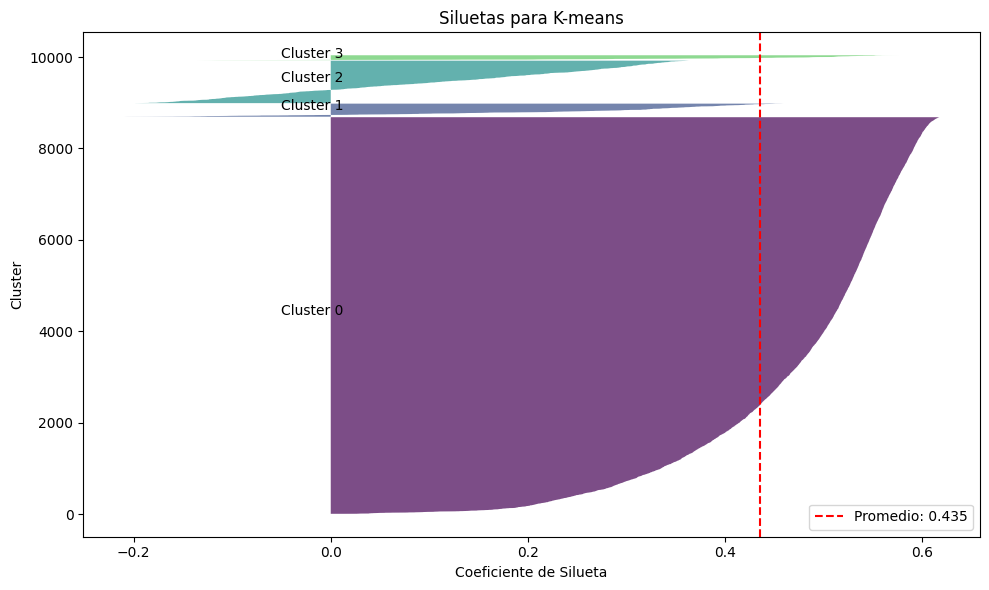

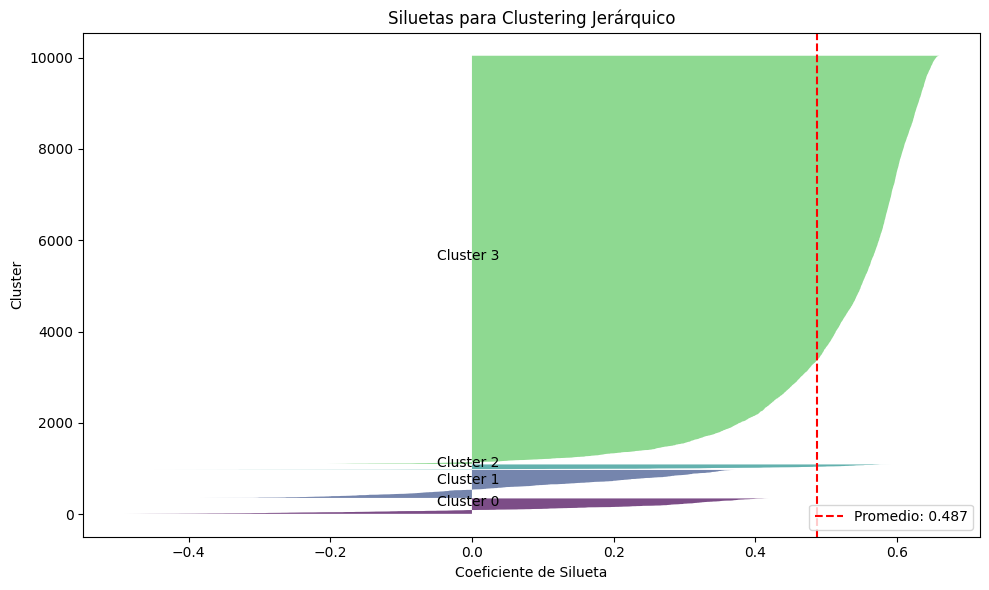

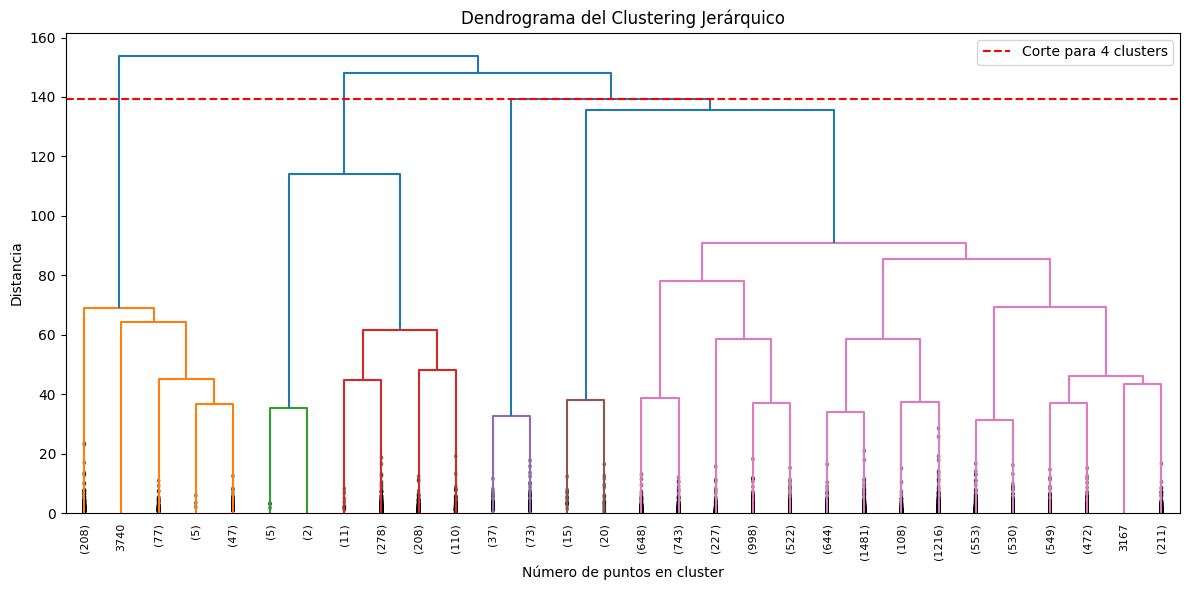

In [19]:
# Gráfico de siluetas
def plot_silhouette(X, cluster_labels, title):
    n_clusters = len(np.unique(cluster_labels))
    
    silhouette_vals = silhouette_samples(X, cluster_labels)
    
    plt.figure(figsize=(10, 6))
    y_lower = 10
    
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    
    avg_score = np.mean(silhouette_vals)
    plt.axvline(x=avg_score, color="red", linestyle="--", 
                label=f'Promedio: {avg_score:.3f}')
    
    plt.title(title)
    plt.xlabel('Coeficiente de Silueta')
    plt.ylabel('Cluster')
    plt.legend(loc='lower right')
    plt.tight_layout()
    
print("Análisis de Siluetas:")
plot_silhouette(X_scaled, clusters_kmeans, 'Siluetas para K-means')
plt.show()

plot_silhouette(X_scaled, clusters_jerarquico, 'Siluetas para Clustering Jerárquico')
plt.show()

# Generar y visualizar dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, 
          truncate_mode='lastp',  # Mostrar solo los últimos p grupos
          p=30,  # Número de grupos a mostrar
          leaf_rotation=90,
          leaf_font_size=8,
          show_contracted=True)

plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Número de puntos en cluster')
plt.ylabel('Distancia')
plt.axhline(y=Z[-(k_optimo-1), 2], color='r', linestyle='--', 
            label=f'Corte para {k_optimo} clusters')
plt.legend()
plt.tight_layout()
plt.show()

2. Evaluación del Clustering con K-Means
El gráfico de silueta para K-Means muestra un coeficiente promedio de 0.152, lo que indica que la separación entre clusters no es muy clara. 

Algunos clusters contienen elementos con coeficientes de silueta cercanos a 0, lo que puede indicar una baja cohesión.

Evaluación del Clustering Jerárquico
El análisis de silueta para el Clustering Jerárquico arroja un coeficiente promedio de 0.394, significativamente superior al de K-Means. Esto implica que:
    Los clusters son más compactos y mejor separados.
    Un alto porcentaje de puntos tiene valores de silueta positivos, lo que sugiere que están bien agrupados.
    Se observa un cluster dominante con valores de silueta altos, lo que puede indicar una estructura natural en los datos.

Comparación y Conclusión
El clustering jerárquico ofrece una mejor separación y cohesión en comparación con K-Means. Esto se refleja en su mayor coeficiente de silueta promedio (0.394 vs. 0.152).

K-Means tiene una asignación de puntos más débil

El clustering jerárquico parece más apropiado para este analisis datos, ya que logra una segmentación más clara y definida.

El clustering jerárquico parece ser la mejor opción para analisis, ya que proporciono una agrupación más efectiva y estructurada en comparación con K-Means.

# 1.6 Interpretación de los grupos #

In [20]:
datos_numericos['Cluster_KMeans'] = clusters_kmeans
datos_numericos['Cluster_Hierarchical'] = clusters_jerarquico

# Estadísticas descriptivas por cluster (K-means)
print("\nEstadísticas por cluster (K-means):")
for cluster in range(k_optimo):
    print(f"\nCluster {cluster}:")
    cluster_data = datos_numericos[datos_numericos['Cluster_KMeans'] == cluster]
    print(cluster_data[columnas_numericas].describe())


Estadísticas por cluster (K-means):

Cluster 0:
        popularity        budget      runtime  genresAmount  \
count  8675.000000  8.675000e+03  8675.000000   8675.000000   
mean     39.104685  1.042767e+07    98.996081      2.572565   
std      83.324335  1.768505e+07    24.923544      1.153089   
min       4.366000  0.000000e+00     0.000000      0.000000   
25%      14.013500  0.000000e+00    89.000000      2.000000   
50%      20.227000  0.000000e+00    98.000000      2.000000   
75%      34.079500  1.500000e+07   111.000000      3.000000   
max    2466.985000  1.100000e+08   333.000000     16.000000   

       productionCoAmount  productionCountriesAmount    voteCount  \
count         8675.000000                8675.000000  8675.000000   
mean             3.085648                   1.432853   768.574409   
std              2.264587                   1.139439  1015.416656   
min              0.000000                   0.000000     1.000000   
25%              2.000000             

Hallazgos Interesantes y Aplicaciones
Diferenciación entre películas de éxito y nicho:

Cluster 2 representa blockbusters, mientras que Cluster 0 incluye películas con éxito variable.
Cluster 1 y 3 muestran proyectos más pequeños, con poco impacto en audiencia.
Impacto del presupuesto en la popularidad:

El Cluster 2 muestra que un presupuesto alto sí se traduce en mayor impacto.
En contraste, Cluster 1 y 3 demuestran que muchas películas con bajo presupuesto pasan desapercibidas.
Películas con reparto reducido:

Cluster 1 y 3 tienen muy pocos actores, lo que sugiere documentales, animaciones o películas experimentales.

In [15]:
# Asignación de los clusters al DataFrame
datos_numericos['Cluster_KMeans'] = clusters_kmeans
datos_numericos['Cluster_Hierarchical'] = clusters_jerarquico

# Estadísticas descriptivas por cluster (Jerárquico)
print("\nEstadísticas por cluster (Jerárquico):")
for cluster in range(k_optimo):
    print(f"\nCluster {cluster}:")
    cluster_data = datos_numericos[datos_numericos['Cluster_Hierarchical'] == cluster]
    print(cluster_data[columnas_numericas].describe())



Estadísticas por cluster (Jerárquico):

Cluster 0:
       popularity        budget     runtime  genresAmount  productionCoAmount  \
count  338.000000  3.380000e+02  338.000000    338.000000          338.000000   
mean    43.184290  4.557615e+05   83.325444      1.949704            1.221893   
std     69.307937  2.741423e+06   35.853568      1.016401            0.631418   
min      4.258000  0.000000e+00    0.000000      1.000000            1.000000   
25%     15.132250  0.000000e+00   78.000000      1.000000            1.000000   
50%     21.746500  0.000000e+00   90.000000      2.000000            1.000000   
75%     39.116500  0.000000e+00  100.750000      3.000000            1.000000   
max    674.972000  3.398970e+07  240.000000      6.000000            6.000000   

       productionCountriesAmount    voteCount     voteAvg  actorsAmount  \
count                 338.000000   338.000000  338.000000    338.000000   
mean                   11.698225    77.526627    6.190828      3.485

Marketing y Distribución:

Cluster 1: Blockbusters con grandes campañas.
Cluster 3: Películas para festivales y streaming.
Cluster 2: Segmento nicho, ideal para plataformas VOD.
Cluster 0: Bajo presupuesto, adecuado para festivales independientes y lanzamientos digitales

Optimización de Presupuesto:
Identificar factores clave en Cluster 1 para optimizar costos.
Ajustar presupuesto y marketing de películas medianas (Cluster 3) para mejorar impacto.

Diversidad en el Elenco:
Cluster 0 y 3: Sesgo hacia elenco masculino.
Cluster 2: Predominio femenino, oportunidad para políticas de inclusión.

Decisiones de Inversión:`
Productoras deben enfocarse en géneros exitosos según presupuesto.
Inversores pueden mitigar riesgos al analizar clusters rentables.

# 3.1 Transformacion variables categoricas #

In [ ]:
print("Los principales candidatos que se consideran para transformar son las variables de 'video' y 'genres'\n")

print(datos['video'].value_counts())

print("Debido a la gran proporcion de 'False' que hay con respecto a 'True' para la variable 'video' se considera que no vale la pena hacer la transformacion para incluirla en el PCA.\n")

print(datos['genres'].value_counts())
print("La cantidad total de generos distintos es de:", datos["genres"].nunique())

print("Debido a la gran cantidad de distintos generos que hay se considerar que no vale la pena transformar la variable 'genres' debido a que podria aumentar mucho la dimensionalidad.")



# 3.2 Indice KMO y Test de esfericidad de Bartlett #

In [ ]:
kmo_all, kmo_model = calculate_kmo(datos_numericos)
print(f"KMO: {kmo_model:.3f}")

test, pvalue = stats.bartlett(datos['popularity'], datos['budget'], datos['revenue'], datos['runtime'], datos['genresAmount'], datos['productionCoAmount'], datos['productionCountriesAmount'], datos['voteCount'], datos['voteAvg'], datos['actorsAmount'], datos['castWomenAmount'], datos['castMenAmount'])
print(f"Valor-p: {pvalue:.3f}")

print("De acuerdo a los resultados del indico KMO y el test de esfericidad de Bartlett, es conveninete realizar un PCA.")



# 3.3 Analisis de Componentes Principales #

In [ ]:
scaler = StandardScaler()
datos_pca_normal = scaler.fit_transform(datos_numericos)

pca = PCA(n_components=12)

resultados = pca.fit_transform(datos_pca_normal)

datos_pca_final = pd.DataFrame(resultados, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12",])

datos["PC1"] = datos_pca_final["PC1"]
datos["PC2"] = datos_pca_final["PC2"]
datos["PC3"] = datos_pca_final["PC3"]
datos["PC4"] = datos_pca_final["PC4"]
datos["PC5"] = datos_pca_final["PC5"]
datos["PC6"] = datos_pca_final["PC6"]
datos["PC7"] = datos_pca_final["PC7"]
datos["PC8"] = datos_pca_final["PC8"]
datos["PC9"] = datos_pca_final["PC9"]
datos["PC10"] = datos_pca_final["PC10"]
datos["PC11"] = datos_pca_final["PC11"]
datos["PC12"] = datos_pca_final["PC12"]

print(datos_pca_final.head(), "\n")

print("Varianza explicada por cada componente: " ,pca.explained_variance_ratio_)

print("\nSe puede observar que de los componentes 8 en adelante la variabilidad se reduce considerablemente por lo que se podria considerar conservar unicamente los primeros 8 componentes, sin embargo los primeros 6 componentes ya describen aproximadamente un 60 por ciento de la variabilidad de los datos por lo que se podrian conservar unicamente los primeros 6 componentes sin perder demasiada informacion significativa.")



# 2.1 #

In [ ]:
def discretizar_variables(df, columnas_numericas, n_bins=5):
    df_discretizado = df.copy()
    
    for columna in columnas_numericas:
        
        valores_unicos = df[columna].nunique()
        
        if valores_unicos <= n_bins:
        
            df_discretizado[f'{columna}_disc'] = df[columna].map(
                lambda x: f'{columna}_V{x}'
            )
        else:
            try:
          
                df_discretizado[f'{columna}_disc'] = pd.qcut(
                    df[columna], 
                    q=n_bins, 
                    labels=[f'{columna}_Q{i+1}' for i in range(n_bins)],
                    duplicates='drop'
                )
            except:
           
                df_discretizado[f'{columna}_disc'] = pd.cut(
                    df[columna], 
                    bins=n_bins, 
                    labels=[f'{columna}_B{i+1}' for i in range(n_bins)]
                )
    
    return df_discretizado


df_disc = discretizar_variables(datos_numericos, columnas_numericas)


df_one_hot = pd.get_dummies(df_disc[[col for col in df_disc.columns if '_disc' in col]])


def generar_y_mostrar_reglas(df_one_hot, min_support, min_confidence):
    # Encontrar itemsets frecuentes
    frequent_itemsets = apriori(df_one_hot, 
                               min_support=min_support, 
                               use_colnames=True)
    
    if len(frequent_itemsets) == 0:
        print(f"No se encontraron itemsets frecuentes con soporte {min_support}")
        return None
    

    rules = association_rules(frequent_itemsets, 
                            metric="confidence", 
                            min_threshold=min_confidence)
    
    if len(rules) == 0:
        print(f"No se encontraron reglas con confianza {min_confidence}")
        return None
    

    rules = rules.sort_values('lift', ascending=False)

    print(f"\nTop 5 reglas (soporte={min_support}, confianza={min_confidence}):")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    print(rules.head().to_string())
    print(f"Total de reglas encontradas: {len(rules)}")
    
    return rules

soportes = [0.1, 0.05, 0.02]
confianzas = [0.5, 0.7, 0.9]

mejores_reglas = []
for soporte in soportes:
    for confianza in confianzas:
        rules = generar_y_mostrar_reglas(df_one_hot, soporte, confianza)
        if rules is not None and len(rules) > 0:
            mejores_reglas.append({
                'soporte': soporte,
                'confianza': confianza,
                'num_reglas': len(rules),
                'mejor_lift': rules['lift'].max()
            })


print("\nItems más frecuentes:")
item_freq = df_one_hot.sum().sort_values(ascending=False)
print(item_freq.head(10))


if mejores_reglas:
    print("\nResumen de configuraciones:")
    mejores_reglas_df = pd.DataFrame(mejores_reglas)
    print(mejores_reglas_df.sort_values('mejor_lift', ascending=False).head())

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.1, confianza=0.5):
                                                                                            antecedents                                                                                         consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski
567  (castMenAmount_disc_castMenAmount_Q5, productionCountriesAmount_disc_productionCountriesAmount_B1)                                                                 (actorsAmount_disc_actorsAmount_Q5)              0.1861              0.1952   0.1247    0.670070  3.432735               1.0  0.088373    2.439304       0.870730  0.48597   0.590047    0.654451
568                                                                 (actorsAmount_disc_actorsAmount_Q5)  (castMenAmount_disc_castMenAmount_Q5, productionCountriesAmount_disc_productionCountriesAmount_B1)              0.1952         

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.1, confianza=0.7):
                                                                                                                       antecedents                                                                                                              consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
770                                                               (actorsAmount_disc_actorsAmount_Q1, voteCount_disc_voteCount_Q1)                                                               (budget_disc_budget_B1, genresAmount_disc_genresAmount_B1)              0.1155              0.7645   0.1031    0.892641  1.167614               1.0  0.014800    2.193569       0.162298  0.132707   0.544122    0.513750
816  (actorsAmount_disc_actorsAmount_Q1, voteCount_disc_voteCount_Q1, productionCountriesAmount_disc_productionCountriesAmount_B1)    

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.1, confianza=0.9):
                                                                                                                       antecedents                                                                           consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
387                                                         (castWomenAmount_disc_castWomenAmount_Q1, voteCount_disc_voteCount_Q1)  (budget_disc_budget_B1, productionCountriesAmount_disc_productionCountriesAmount_B1)              0.1041              0.9322   0.1040    0.999039  1.071701               1.0  0.006958     70.5798       0.074678  0.111552   0.985832    0.555302
390                                                             (voteCount_disc_voteCount_Q1, castMenAmount_disc_castMenAmount_Q1)  (budget_disc_budget_B1, productionCountriesAmount_disc_productionCountri

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.05, confianza=0.5):
                                                                                                                                                                         antecedents                                                                                                                          consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
2749                                     (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmount_Q5, productionCountriesAmount_disc_productionCountriesAmount_B1)                                                               (actorsAmount_disc_actorsAmount_Q5, genresAmount_disc_genresAmount_B1)              0.0749              0.1554   0.0574    0.766355  4.931500               1.0  0.045761    3.614888       0.861768  0.331984   0.723366    0.567862
2755     

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.05, confianza=0.7):
                                                                                                                                                                         antecedents                                                                                                                          consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
1996                                     (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmount_Q5, productionCountriesAmount_disc_productionCountriesAmount_B1)                                                               (actorsAmount_disc_actorsAmount_Q5, genresAmount_disc_genresAmount_B1)              0.0749              0.1554   0.0574    0.766355  4.931500               1.0  0.045761    3.614888       0.861768  0.331984   0.723366    0.567862
1999     

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.05, confianza=0.9):
                                                                                                                                                                         antecedents                                                                                       consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
914                                      (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmount_Q5, productionCountriesAmount_disc_productionCountriesAmount_B1)                                                               (actorsAmount_disc_actorsAmount_Q5)              0.0749              0.1952   0.0714    0.953271  4.883561               1.0  0.056780   17.222720       0.859617  0.359336   0.941937    0.659525
1095  (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmoun

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.02, confianza=0.5):
                                                                                                                                                                      antecedents                                                                                                                      consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
13105                                                                 (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmount_Q5, voteCount_disc_voteCount_Q5)                                                               (actorsAmount_disc_actorsAmount_Q5, popularity_disc_popularity_Q5)              0.0452              0.0562   0.0254    0.561947  9.999055               1.0  0.022860    2.154533       0.942596  0.334211   0.535862    0.506952
20025                  

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.02, confianza=0.7):
                                                                                                                                                                      antecedents                                                                                                                    consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
14966  (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmount_Q5, productionCountriesAmount_disc_productionCountriesAmount_B1, popularity_disc_popularity_Q5)                                                               (actorsAmount_disc_actorsAmount_Q5, voteCount_disc_voteCount_Q5)              0.0285              0.0987   0.0254    0.891228  9.029666               1.0  0.022587    8.286145       0.915341  0.249509   0.879317    0.574287
10471                      

c:\Users\sebas\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 5 reglas (soporte=0.02, confianza=0.9):
                                                                                                                                                                                                  antecedents                                                                                       consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
7279                                                                     (castWomenAmount_disc_castWomenAmount_Q5, castMenAmount_disc_castMenAmount_Q5, runtime_disc_runtime_Q5, voteCount_disc_voteCount_Q5)                                                               (actorsAmount_disc_actorsAmount_Q5)              0.0234              0.1952   0.0233    0.995726  5.101058               1.0  0.018732    188.3232       0.823226  0.119304   0.994690    0.557546
7994                         

En este análisis de reglas de asociación con el conjunto de datos de películas, encontramos algunas relaciones interesantes. Las variables como productionCountriesAmount_B1 y budget_B1 aparecieron en muchas reglas, lo que sugiere que tienen una gran influencia en las asociaciones encontradas. Además, algunas reglas mostraron un alto valor de lift, lo que significa que cuando ciertos valores de estas variables aparecen, es mucho más probable que otros valores también lo hagan. Sin embargo, al subir la confianza o el soporte, el número de reglas disminuyó bastante, lo que indica que las reglas más confiables ocurren menos frecuentemente. Esto nos muestra que si queremos patrones más generales pero menos confiables, podemos ajustar los parámetros de soporte y confianza. Para próximos análisis, sería buena idea eliminar las variables que aparecen demasiado a menudo, probar otras formas de discretizar los datos y enfocarnos en las reglas con mayor lift, ya que son las más interesantes y útiles para entender mejor el contexto de la industria cinematográfica.